In [131]:
import numpy as np
import os

SUBJECT_NAME = 'New10Subject1'

# collect all data
all_experiments = os.listdir(SUBJECT_NAME)
data = [] # list of numpy arrays of shape (n_samples, 84, 93)
labels = [] # list of numpy arrays of shape (n_samples, 1)
for experiment in all_experiments:
    data.append(np.load(os.path.join(SUBJECT_NAME, experiment, f'{experiment}PreprocessedData.npy')))
    labels.append(np.load(os.path.join(SUBJECT_NAME, experiment, f'{experiment}Labels.npy'), allow_pickle=True))
labels = [label[:-1, 2].astype('float').astype('int') for label in labels] # drop the last label to make it the same length as the data
data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)

print("Total number of samples: ", data.shape[0])
assert data.shape[0] == labels.shape[0], "Data and labels have different lengths"
label_counts = np.bincount(labels)
print("Number of each label: ", label_counts)

# further data preprocessing
random_32_label_0_indices = np.random.choice(np.where(labels == 0)[0], size=32, replace=False)
final_indices = np.concatenate([random_32_label_0_indices, np.where(labels != 0)[0]])
np.random.shuffle(final_indices)
data = data[final_indices]
labels = labels[final_indices]
label_counts = np.bincount(labels)
print("Number of each label after dropping label 0: ", label_counts)

Total number of samples:  637
Number of each label:  [317  32  32  32  32  32  32  32  32  32  32]
Number of each label after dropping label 0:  [32 32 32 32 32 32 32 32 32 32 32]


In [132]:
import mne

# Events array: (n_events, 3) with [start_sample, 0, event_id]
events = np.array([[i * data.shape[2], 0, label] for i, label in enumerate(labels)])

# Create Epochs object
# Define channel names (e.g., hbo1, hbr1, ..., hbo42, hbr42)
channel_names = [f'{channel}{i + 1}' for i in range(42) for channel in ['hbo', 'hbr']]
channel_types = ["hbo", "hbr"] * 42

# Sampling rate
sfreq = 6.1  # Hz
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=channel_types)
epochs = mne.EpochsArray(data, info, events=events)
epochs = epochs.drop_channels(['hbo27', 'hbr27', 'hbo28', 'hbr28'])

# remove label 0
epochs = epochs[labels != 0]
labels = labels[labels != 0]

Not setting metadata
352 matching events found
No baseline correction applied
0 projection items activated


In [133]:
# do some dimension reduction through PCA — find a way to decrease the number of channels
from sklearn.decomposition import PCA
from mne.decoding import UnsupervisedSpatialFilter
pca = UnsupervisedSpatialFilter(PCA(n_components=20))
data_pca = pca.fit_transform(epochs.pick("hbo").get_data())
data_pca.shape

# data_pca = epochs.pick("hbr").get_data()
# data_pca.shape

(320, 20, 93)

(320, 60)
Cross validation scores:  [0.09375 0.09375 0.09375 0.09375 0.0625 ]


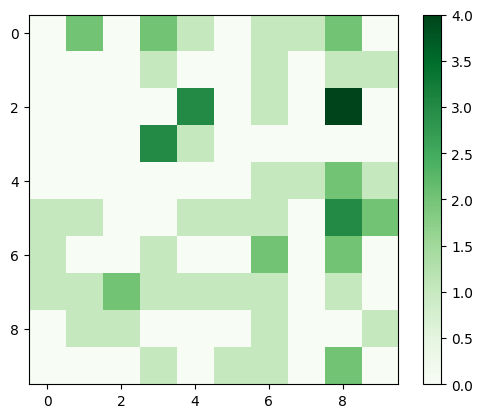

In [134]:
# extract variance per channel as a feature
# extract PSD per channel as a feature NOT YET 
# use this to evaluate a random forest classifier, a linear SVM, and a logitic regression


# extract manual features: mean, variance, skewness, kurtosis, max, range

from scipy.stats import skew, kurtosis

def extract_features(data):
    means = np.mean(data, axis=2)
    variances = np.var(data, axis=2)
    skews = skew(data, axis=2)
    kurtoses = kurtosis(data, axis=2)
    maxes = np.max(data, axis=2)
    
    features = np.concatenate([means, variances, maxes], axis=1)
    return features

features = extract_features(data_pca)
print(features.shape)

# evaluate a random forest classifier, also producing a confusion matrix to show the 10 classes

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, features, labels, cv=5)
print("Cross validation scores: ", scores)

# confusion matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, cmap='Greens', interpolation='nearest')
plt.colorbar()
plt.show()

In [135]:
y_test

array([ 5,  9,  1,  5,  6,  7,  3,  8,  3,  7,  5,  3,  4,  3,  1,  8,  1,
        8,  2, 10,  6,  7, 10,  6,  8,  6,  5,  6,  5,  8,  9,  1,  6,  3,
        8,  3,  1,  2,  4,  7,  3,  7,  4,  4,  3,  8,  1,  7,  2,  9,  2,
        1,  6, 10,  6, 10,  1, 10,  6,  1,  8,  8,  9,  6])

In [117]:
y_pred

array([ 1,  1,  7,  8,  0,  0,  9,  1,  3,  5,  9,  7,  1,  1,  8,  1,  2,
        2,  7,  8,  1,  7, 10,  5,  5,  6,  7,  8,  9,  7,  1,  1,  3,  1,
        1,  1,  4,  6,  5,  1,  7,  2, 10,  0,  7,  3, 10,  8,  6,  7,  0,
        6,  5,  1,  2,  1,  4, 10,  7,  0,  6,  5,  7,  1,  2,  2,  0,  1,
        8,  3,  3])